In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle # to save parameters

### (a)Implement both forward-propagation and back-propagation

In [2]:
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

In [3]:
def prepare_data():
    np.random.seed(100)
    trainData, trainLabels = readData('images_train.csv', 'labels_train.csv')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]
    #normalize each feature to have mean 0 and variance 1
    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    testData, testLabels = readData('images_test.csv', 'labels_test.csv')
    testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std
    return trainData, trainLabels, devData, devLabels, testData, testLabels

In [4]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    # x: BXK, batchsizeXnumber of classes
    c = np.max(x, axis=1, keepdims=True)
    num = np.exp(x-c) #numerical stability
    deno = np.sum(num, axis=1,keepdims=True)
    s = num / deno
    ### END YOUR CODE
    return s

In [5]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE
    x = x.astype(np.float32)
    s = 1/(1+np.exp(-x))
    ### END YOUR CODE
    return s

In [6]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    data: BX784
    labels: BX10
    """
    W1 = params['W1'] # 784XH
    b1 = params['b1'] # BXH
    W2 = params['W2'] # HX10
    b2 = params['b2'] # BX10

    ### YOUR CODE HERE
    z1 = data.dot(W1)+b1
    h = sigmoid(z1)
    z2 = h.dot(W2)+b2
    y = softmax(z2)
    
    loss = -np.multiply(labels, np.log(y+1e-12)).sum()
    loss /= data.shape[0]
    ### END YOUR CODE
    return h, y, loss

In [7]:
def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    h, y, cost = forward_prop(data, labels, params)
    
    delta1 = y-labels
    gradW2 = np.dot(h.T, delta1)
    gradb2 = np.sum(delta1, axis=0,keepdims=True)
    
    delta2 = np.dot(delta1,W2.T)*h*(1-h)#multiply
    gradW1 = np.dot(data.T, delta2)
    gradb1 = np.sum(delta2, axis=0,keepdims=True)
    
    # consider regularization
    lam = params['lambda']
    gradW2 += lam*W2
    gradW1 += lam*W1
    
    B = data.shape[0]
    gradW2 /= B
    gradb2 /= B 
    gradW1 /= B 
    gradb1 /= B 
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

In [8]:
def gradient_descent(params, grad, learning_rate):
    params['W1'] -= learning_rate*grad['W1']
    params['b1'] -= learning_rate*grad['b1']
    params['W2'] -= learning_rate*grad['W2']
    params['b2'] -= learning_rate*grad['b2']

In [9]:
def nn_train(trainData, trainLabels, devData, devLabels,\
            num_hidden = 300,learning_rate = 5,batch_size = 1000,\
            num_epochs = 30,reg_strength=0):
    (m, n) = trainData.shape
    # add extra parameter options
    params = {}

    ### YOUR CODE HERE
    K = trainLabels.shape[1] 
    H = num_hidden 
    B = batch_size
    
    params['W1'] = np.random.randn(n,H)
    params['b1'] = np.zeros((1,H),dtype=float)
    params['W2'] = np.random.randn(H,K)
    params['b2'] = np.zeros((1,K),dtype=float)
    params['lambda'] = reg_strength
    
    #print(type(params['W1']))
    #print(params['W1'].shape)
    
    num_iter = int(m/B) # number of iterations per epoch
    train_loss, train_acc, dev_loss,dev_acc = [],[],[],[]
    for i in range(num_epochs):
        print('epoch = ',i)
        for j in range(num_iter):
            batch_data = trainData[j*B:(j+1)*B]
            batch_labels = trainLabels[j*B:(j+1)*B]
            grad = backward_prop(batch_data,batch_labels,params)
            gradient_descent(params,grad,learning_rate)
        # calculate accuray per epoch
        _, y, cost = forward_prop(trainData,trainLabels,params)
        train_loss.append(cost)
        train_acc.append(compute_accuracy(y, trainLabels))
        _, y, cost = forward_prop(devData,devLabels,params)
        dev_loss.append(cost)
        dev_acc.append(compute_accuracy(y, devLabels))
        
        ### END YOUR CODE

    return params, train_loss, train_acc, dev_loss, dev_acc

In [10]:
def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

In [11]:
# download dataset and observe time consuming
%time trainData, trainLabels, devData, devLabels, testData, testLabels = prepare_data()

Wall time: 31.4 s


In [12]:
# trian our nn: parameters updation and track loss/accuracy 
params, train_loss, train_acc, dev_loss, dev_acc=\
nn_train(trainData, trainLabels, devData, devLabels)

epoch =  0


D:\anaconda\anacondaInstall\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
epoch =  18
epoch =  19
epoch =  20
epoch =  21
epoch =  22
epoch =  23
epoch =  24
epoch =  25
epoch =  26
epoch =  27
epoch =  28
epoch =  29


In [13]:
# save parameters
with open('parameters_without_regularization.pkl','wb') as opf:
    pickle.dump(params, opf)
# load parameters
#with open('parameters_without_regularization.pkl','rb') as inf:
#    params = pickle.load(inf)

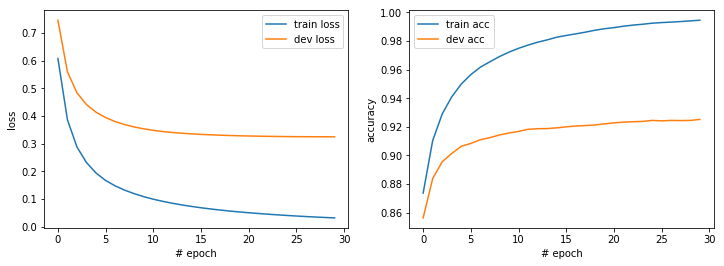

In [14]:
xs = np.arange(30) #np.arange used to generate axis

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, train_loss, label='train loss')
plt.plot(xs, dev_loss, label='dev loss')
plt.legend()
plt.xlabel('# epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(xs, train_acc, label='train acc')
plt.plot(xs, dev_acc, label='dev acc')
plt.legend()
plt.xlabel('# epoch')
plt.ylabel('accuracy')

plt.show()

### (b) Add a regularization term to cross entropy loss

In [15]:
# trian our nn: parameters updation and track loss/accuracy 
params, train_loss, train_acc, dev_loss, dev_acc=\
nn_train(trainData, trainLabels, devData, devLabels,reg_strength=0.3)

epoch =  0


D:\anaconda\anacondaInstall\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
epoch =  18
epoch =  19
epoch =  20
epoch =  21
epoch =  22
epoch =  23
epoch =  24
epoch =  25
epoch =  26
epoch =  27
epoch =  28
epoch =  29


In [16]:
# save parameters
with open('parameters_with_regularization.pkl','wb') as opf:
    pickle.dump(params, opf)
# load parameters
#with open('parameters_with_regularization.pkl,'rb') as inf:
#    params = pickle.load(inf)

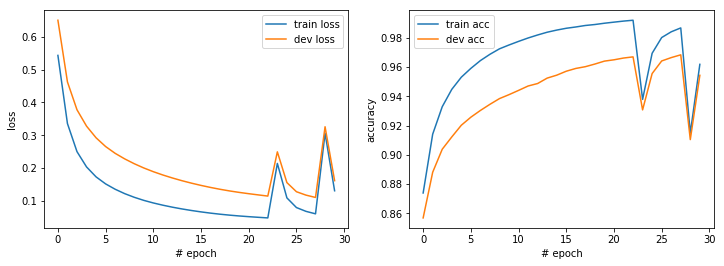

In [17]:
xs = np.arange(30)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, train_loss, label='train loss')
plt.plot(xs, dev_loss, label='dev loss')
plt.legend()
plt.xlabel('# epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(xs, train_acc, label='train acc')
plt.plot(xs, dev_acc, label='dev acc')
plt.legend()
plt.xlabel('# epoch')
plt.ylabel('accuracy')

plt.show()

**comparision**: compare the plots obtained from the regularized version with the plots obtained from the non-regularized version, we can find that with regularizaiton term, the overfitting problem can be solved a lot. Training loss and dev loss curve are close enough with the help of regularized term.

### (c) measure the model performance on the test set

In [18]:
# test accuracy without regularization
with open('parameters_without_regularization.pkl','rb') as inf:
    params = pickle.load(inf)
accuracy = nn_test(testData, testLabels, params)
print('test accuracy without regularization: {0}'.format(accuracy))


#test accuracy with regularization
with open('./parameters_with_regularization.pkl','rb') as inf:
    params = pickle.load(inf)
accuracy = nn_test(testData, testLabels, params)
print('test accuracy with regularization: {0}'.format(accuracy))

D:\anaconda\anacondaInstall\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


test accuracy without regularization: 0.9283
test accuracy with regularization: 0.9554
